In [1]:
from google.colab import drive
drive.mount('/content/drive/')

MessageError: ignored

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Projects/reddit-vote-predictor')
import sys
import shutil as sh
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats as s
from skimage import io
from mpl_toolkits.axes_grid1 import ImageGrid
import datetime as dt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from PIL import Image
import requests
from io import BytesIO

In [ ]:
print(torch.cuda.is_available())  # Should print True
print(torch.cuda.get_device_name(0))  # Prints the GPU name


True
Tesla T4


In [ ]:
# Read in the data
dog = pd.read_csv("data/dog_model_data.csv")
# If the image is not hosted on reddit, then use the url to the thumbnail
condition = ~dog.url.str.contains('redd.it')
dog.loc[condition, 'FEATURE'] = dog.loc[condition, 'thumbnail']

In [ ]:
# Check that images exist within the above-filtered url's
def check_image_exists(url):
    try:
        response = requests.get(url)
        return response.status_code == 200
    except requests.RequestException:
        return False

# Add a new column 'image_found' indicating if an image exists at the URL
dog['image_found'] = dog['FEATURE'].apply(check_image_exists)

,score,FEATURE,url,thumbnail,thumbnail_height
6,0,http://b.thumbs.redditmedia.com/BsqpU0Bqw0OtE1...,http://i.imgur.com/DYfcy2A.png,http://b.thumbs.redditmedia.com/BsqpU0Bqw0OtE1...,NaN
7,0,http://b.thumbs.redditmedia.com/AwTvKfOYDpo43L...,http://static.rappler.com/images/biggest-canin...,http://b.thumbs.redditmedia.com/AwTvKfOYDpo43L...,NaN
9,0,NaN,https://i.redd.it/w5h9tdu9mg061.jpg,https://b.thumbs.redditmedia.com/HRZFTfa5jcv8g...,140.0
49,0,https://a.thumbs.redditmedia.com/IH7qkOrK77Q45...,https://i.imgur.com/BgOGgEB.jpg,https://a.thumbs.redditmedia.com/IH7qkOrK77Q45...,93.0
65,0,NaN,https://i.redd.it/idxtd3qoilg01.jpg,https://a.thumbs.redditmedia.com/3TjVBP949jumK...,140.0
...,...,...,...,...,...
693,0,NaN,https://i.redd.it/rducfu63g7o21.jpg,https://b.thumbs.redditmedia.com/foyde_M03WqIW...,139.0
718,0,http://b.thumbs.redditmedia.com/kzXN4kxzMOXQch...,http://i.imgur.com/rtyhFUx.jpg,http://b.thumbs.redditmedia.com/kzXN4kxzMOXQch...,NaN
743,0,NaN,https://i.redd.it/n6vx3v8jmnr41.jpg,https://b.thumbs.redditmedia.com/CChNuzgBe_0aD...,140.0
751,0,NaN,https://i.redd.it/b3wqjyfiq9x51.jpg,https://b.thumbs.redditmedia.com/8DADPNZDODOKn...,105.0


In [ ]:
dog[dog['score'] == 0][['score', 'FEATURE', 'url', 'thumbnail', 'thumbnail_height']]

In [ ]:
dog['created_date'] = pd.to_datetime(dog['created_date'])
dog['dmy'] = dog['created_date'].dt.strftime('%Y-%m-%d')
dog['weekday'] = dog['created_date'].dt.day_name()
dog['year'] = dog['created_date'].dt.year
dog = dog.sort_values('created_date')
dog['year_start'] = ~dog['year'].duplicated()
dog

/usr/local/lib/python3.10/dist-packages/IPython/lib/pretty.py:700: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/usr/local/lib/python3.10/dist-packages/google/colab/_interactive_table_hint_button.py:162: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_html=dataframe._repr_html_(),


,author,created_utc,is_video,num_comments,pinned,post_hint,retrieved_on,score,subreddit,subreddit_subscribers,...,created,created_date,quantile,score_per_day,score_per_sub,img_path,dmy,weekday,year,year_start
425,sharongu,1426649300,NaN,0,NaN,image,1.440847e+09,3,DOG,NaN,...,1.426649e+09,2015-03-18 03:28:20,q1,0.001062,NaN,data/img/cat/425 (1).png,2015-03-18,Wednesday,2015,True
584,KittyCommand0R,1432763811,NaN,0,NaN,image,1.440710e+09,0,DOG,NaN,...,1.432764e+09,2015-05-27 21:56:51,q1,0.000000,NaN,data/img/cat/584 (1).png,2015-05-27,Wednesday,2015,False
337,D3lux3,1436553157,NaN,0,NaN,image,1.440620e+09,2,DOG,NaN,...,1.436553e+09,2015-07-10 18:32:37,q1,0.000737,NaN,data/img/cat/337 (1).png,2015-07-10,Friday,2015,False
1715,NuclearNancy,1436800802,NaN,0,NaN,image,1.440614e+09,9,DOG,NaN,...,1.436801e+09,2015-07-13 15:20:02,q3,0.003322,NaN,data/img/cat/1715 (1).png,2015-07-13,Monday,2015,False
804,eurekaLG,1436961591,NaN,1,NaN,image,1.440610e+09,5,DOG,NaN,...,1.436962e+09,2015-07-15 11:59:51,q2,0.001847,NaN,data/img/cat/804.png,2015-07-15,Wednesday,2015,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,MissCrazyLady,1608395613,False,0,False,image,1.608398e+09,2,DOG,71143.0,...,1.608396e+09,2020-12-19 16:33:33,q1,0.002766,0.000028,data/img/cat/334 (1).png,2020-12-19,Saturday,2020,False
225,wsidaw,1608397225,False,0,False,image,1.608399e+09,3,DOG,71146.0,...,1.608397e+09,2020-12-19 17:00:25,q1,0.004149,0.000042,data/img/cat/225 (1).png,2020-12-19,Saturday,2020,False
421,FupaTroopAdmiral,1608397570,False,0,False,image,1.608400e+09,2,DOG,71147.0,...,1.608398e+09,2020-12-19 17:06:10,q1,0.002766,0.000028,NaN,2020-12-19,Saturday,2020,False
1011,nisargsd1999,1608400385,False,5,False,image,1.608402e+09,7,DOG,71150.0,...,1.608400e+09,2020-12-19 17:53:05,q2,0.009682,0.000098,data/img/cat/1011 (1).png,2020-12-19,Saturday,2020,False


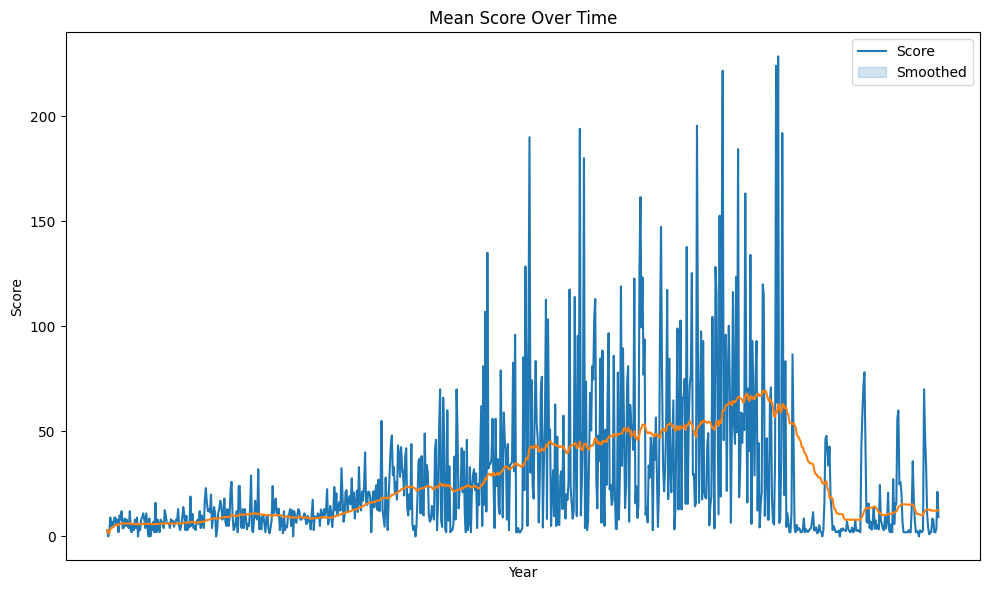

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming you have a DataFrame named 'dd'

# Convert 'created_date' column to datetime
dog['created_date'] = pd.to_datetime(dog['created_date'])

# Add new columns
dog['date_str'] = dog['created_date'].dt.strftime('%Y-%m-%d')
dog['weekday'] = dog['created_date'].dt.day_name()
dog['year'] = dog['created_date'].dt.year

# Sort DataFrame by 'date_str'
dog = dog.sort_values(by='date_str')

# Create a 'year_start' column indicating the start of each year
dog['year_start'] = ~dog['year'].duplicated()

# Group by 'date_str' and calculate mean score
summary_df = dog.groupby('date_str', as_index=False)['score'].mean()
summary_df['smoothed_score'] = summary_df['score'].rolling(window=50, min_periods=1).mean()

# Plot using Matplotlib and Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=summary_df, x='date_str', y='score')
sns.lineplot(data=summary_df, x='date_str', y='smoothed_score')
plt.xticks(rotation=45, ha='right')

# # One label for start of each year:
# # Get unique years for custom x-axis ticks
# years = dog['year'].unique()
# years.sort()
# # Set custom x-axis tick positions and labels
# year_positions = dog.groupby('year').apply(lambda x: x.index[0]).tolist()
# year_labels = [str(year) for year in years]
# plt.xticks(ticks=year_positions, labels=year_labels)
plt.xticks([])

plt.xlabel('Year')
plt.ylabel('Score')
plt.title('Mean Score Over Time')
plt.legend(['Score', 'Smoothed'])
plt.tight_layout()
plt.show()


In [ ]:
# If the image is not hosted on reddit, then use the thumbnail
dog['FEATURE'] = dog['url']
condition = ~dog.url.str.contains('redd.it')
dog.loc[condition, 'FEATURE'] = dog.loc[condition, 'thumbnail']
dog.head(200).to_csv('data/dog_snippet.csv', index = False)
dog.head()

,author,created_utc,is_video,num_comments,pinned,post_hint,retrieved_on,score,subreddit,subreddit_subscribers,...,thumbnail_height,thumbnail_width,url,created,created_date,quantile,score_per_day,score_per_sub,img_path,FEATURE
0,skylinefan26,1566090679,False,0,False,image,1.566091e+09,2,DOG,27523.0,...,140.0,140.0,https://i.redd.it/rk3h0ok4y3h31.jpg,1.566091e+09,2019-08-18 01:11:19,q1,0.001649,0.000073,NaN,https://i.redd.it/rk3h0ok4y3h31.jpg
1,Charming-Usual3101,1605745804,False,0,False,image,1.605757e+09,2,DOG,68725.0,...,140.0,140.0,https://i.redd.it/ca2aigv6b3061.jpg,1.605746e+09,2020-11-19 00:30:04,q1,0.002653,0.000029,data/img/cat/1 (1).png,https://i.redd.it/ca2aigv6b3061.jpg
2,EncyclopediaOfAll,1592671048,False,6,False,image,1.592677e+09,3,DOG,52133.0,...,140.0,140.0,https://i.redd.it/y93debl7f3651.jpg,1.592671e+09,2020-06-20 16:37:28,q1,0.003315,0.000058,data/img/cat/2 (1).png,https://i.redd.it/y93debl7f3651.jpg
3,RuthRinehart1,1506695813,False,0,False,image,1.506787e+09,2,DOG,NaN,...,91.0,140.0,https://www.holidaycottages.co.uk/assets/image...,1.506696e+09,2017-09-29 14:36:53,q1,0.001053,NaN,data/img/cat/3 (1).png,https://b.thumbs.redditmedia.com/TACNrsKFo68-I...
4,sleddriver715,1590766707,False,1,False,image,1.590769e+09,2,DOG,50245.0,...,140.0,140.0,https://i.redd.it/e4v41pom4q151.jpg,1.590767e+09,2020-05-29 15:38:27,q1,0.002157,0.000040,data/img/cat/4 (1).png,https://i.redd.it/e4v41pom4q151.jpg


In [ ]:
# Data Preprocessing
target_file = 'data/dog_snippet.csv'
FEATURE = 'FEATURE'
TARGET = 'score'
#
#data = pd.read_csv(target_file)
data = dog
image_urls = data[FEATURE]
targets = torch.tensor(data[TARGET].values, dtype=torch.float32)

# Resize and normalize images while preserving aspect ratio
transform = transforms.Compose([
    transforms.CenterCrop(224),      # CenterCrop before resizing
    transforms.Resize((224, 224)),  # Resize to a square
    transforms.ToTensor(),
])

# Custom Dataset with URL-based image loading
class CustomDataset(Dataset):
    def __init__(self, image_urls, targets, transform=None):
        self.image_urls = image_urls
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.image_urls)

    def __getitem__(self, idx):
        image_url = self.image_urls[idx]

        try:
            response = requests.get(image_url)
            image = Image.open(BytesIO(response.content))
        except requests.RequestException:
            # Handle network errors here
            raise Exception(f"Error downloading image from {image_url}")

        if self.transform:
            # FIRST FIX COLOR FORMAT
            if image.mode != 'RGB':
                #print('Image Mode:', image.mode)
                image = image.convert('RGB')
            image = self.transform(image)
        target = self.targets[idx]
        return image, target

# Data Loaders
dataset = CustomDataset(image_urls, targets, transform)
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model Architecture
model = models.vgg16(pretrained=True)
# Freeze the pretrained layers
for param in model.parameters():
    param.requires_grad = False
# Modify the last layer for regression
model.classifier[6] = nn.Linear(4096, 1)
# Move the model to the GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss Function and Optimizer
criterion = nn.MSELoss()  # Using Mean Squared Error (MSE) loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 50
print_every = 5
for epoch in range(num_epochs):
    model.train()
    for images, targets in train_loader:
        optimizer.zero_grad()
        images, targets = images.to(device), targets.to(device)  # Move data to GPU
        outputs = model(images)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
    #print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    if (epoch + 1) % print_every == 0:  # Print every 5 epochs
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Inference
model.eval()
test_image_url = 'https://media.cnn.com/api/v1/images/stellar/prod/200313124810-02-rae-golden-retriever.jpg'
try:
    response = requests.get(test_image_url)
    test_image = transform(Image.open(BytesIO(response.content))).unsqueeze(0)
except requests.RequestException:
    raise Exception(f"Error downloading test image from {test_image_url}")

with torch.no_grad():
    test_image = test_image.to(device)  # Move test image to GPU
    predicted_target = model(test_image).item()

print(f"Predicted Target: {predicted_target:.4f}")



Epoch [5/50], Loss: 858.5347
Epoch [10/50], Loss: 923.7002
Epoch [15/50], Loss: 572.0294
Epoch [20/50], Loss: 9821.9307
Epoch [25/50], Loss: 14581.0068
Epoch [30/50], Loss: 3647.3572
Epoch [35/50], Loss: 13237.9473
Epoch [40/50], Loss: 1935.1332
Epoch [45/50], Loss: 684.1613
Epoch [50/50], Loss: 4860.3276
Predicted Target: 32.0301


Save model

In [ ]:
torch.save(model.state_dict(), 'models/dog/vanilla_score_model.pth')

In [ ]:
dog[dog['score']==0].columns

Index(['author', 'created_utc', 'is_video', 'num_comments', 'pinned',
       'post_hint', 'retrieved_on', 'score', 'subreddit',
       'subreddit_subscribers', 'thumbnail', 'thumbnail_height',
       'thumbnail_width', 'url', 'created', 'created_date', 'quantile',
       'score_per_day', 'score_per_sub', 'img_path', 'FEATURE'],
      dtype='object')

De-trend the score.

In [ ]:
# Instead, predict number of comments (or comments / num_subscribers).
# The former is correlated .45 with score, but not correlated with year.
# Note that year is correlated with num subscribers.
# After predicting num comments, a second model can predict score, or
# the NN can predict score / num_comments.
# The second model can also be an NLP model, or accont for other tabular data.

In [ ]:
# Add early stopping: